In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import matplotlib as mpl
from timeit import default_timer as timer

In [2]:
def generate_model(lx,ly,fa,fb):
    """
    generates the inital state of the model on the lattice:
    lx,ly: is the size of the lattice in x and y direction
    fa,fb: are the propabilities that variant a or variant b occupies a spot
    """
    #define propability that spot is not occupied
    f0 = 1 - (fa + fb)  

    if fa + fb > 1:
        print('ERROR: Total fraction larger than 1')
        exit()
        
    #go through each element in the lattice, to assign if element is of Variant A,B or vacant
    #Variant B: 1, Variant A: -1, Vacant spot: 0
    model = np.random.choice([-1, 0, 1], (lx,ly), p = [fa, f0, fb])
    
    return model

In [3]:
def generate_model_oneofA(lx,ly,fb):
    """
    generates the inital state of the model on the lattice:
    lx,ly: is the size of the lattice in x and y direction
    fa,fb: are the propabilities that variant a or variant b occupies a spot
    """
    #define propability that spot is not occupied
    f0 = 1 - fb  

    if fb > 1:
        print('ERROR: Total fraction larger than 1')
        exit()
        
    #assign variant B and unoccupied spots to the positions on the lattice with the given propabilities
    #Variant B: 1, Vacant spot: 0
    model = np.random.choice([0, 1], (lx,ly), p = [f0, fb])
    
    #pick random position and change it to variant A: -1 => one individual of type A just emerged
    i = np.random.randint(0,lx) 
    j = np.random.randint(0,ly) 
    model[i][j] = -1
    
    return model

In [4]:
def iterate_fixation(r,lx,ly,model):
    """
    iterates initial state until one of the variants is fixated using the moran algorithm:
    r = relative fitness of varaiant A
    lx,ly = dimensions of lattice in x and y direction
    model = inital state of the system
    """
    start = timer()
    counter = 0
    fig = plt.figure()
    nA_list = []
    nB_list = []

    while True:
        counter += 1

        test = model.flatten().tolist()
        #check if one mutation has been fixated, so now we either no longer have variant A or B in population
        if 1 not in test or -1 not in test:
            n_vacant = lx*ly - np.count_nonzero(model)     #count vacant states
            nb = test.count(1)            #count states with variant B
            na = test.count(-1)           #count states with variant A


            print('One-race state reached')
            print('vacant = ' + str(n_vacant))
            print('A = ' + str(na))
            print('B = ' + str(nb))
            print('number of total iterations =' + str(counter))
            print()
            break

        #count number of A and B elements
        nA = (model.flatten()==-1).sum()
        nB = (model.flatten()==1).sum()

        nB_list.append(nB)
        nA_list.append(nA)

        #Using Moran model
        
        #A's prob to reproduce (more advantage than B)
        ra = r*nA/(r*nA + nB)
        #B's prob. to reproduce
        rb = nB/(r*nA + nB)

        #A's prob to die
        da = nA/(nA + nB)
        #B's prob. to die
        db = nB/(nA + nB)

        if da > 1 or da < 0 or db > 1 or db < 0:
            print('ERROR: Death prob not physical')
            exit()
        if ra > 1 or ra < 0 or rb > 1 or rb < 0:
            print('ERROR: Survival prob not physical')
            exit()


        #uniform distribution to use as comparison of conditions
        prob_matrix = np.random.random((lx,ly))

        #find indices all vacant spots
        zeros = np.argwhere(model == 0)


        #choose 1 element from the state to die
        i = np.random.randint(0,lx) 
        j = np.random.randint(0,ly) 

        if model[i,j] == 1: #if occupied by B, and if condition is met, eliminate B

            if prob_matrix[i,j] <= db:
                model[i,j] = 0

        elif model[i,j] == -1: #if occupied by A, and if condition is met, eliminate A

            if prob_matrix[i,j] <= da:
                model[i,j] = 0

        else:
            pass

        #choose 1 element from the state to reproduce and if it reproduces, choose closest vacant spot to put new element
        i = np.random.randint(0,lx) 
        j = np.random.randint(0,ly) 
        #find distances of all zeros from reference point 
        #gives for each zero the distance to the choosen element to reproduce
        dist = np.sum((zeros-[i,j])**2, axis=1) #dist will throw an empty array if there are no more zeros (no more vacant spots)

        if dist.size > 0:

            #select point with minimum distance
            index = np.argmin(dist)
            #apply condition

            if model[i,j] == 1: #if occupied by B, and if condition is met, reproduce B and place in closest vacant spot
                if prob_matrix[i,j] <= rb:
                    model[zeros[index][0], zeros[index][1]] = 1
            elif model[i,j] == -1: #if occupied by A, and if condition is met, reproduce A and place in closest vacant spot
                if prob_matrix[i,j] <= ra:
                    model[zeros[index][0], zeros[index][1]] = -1
            else:
                pass

    end = timer()
    
    return (nA_list, nB_list, counter)
    

In [5]:
def plot_func(nA_list, nB_list, counter,r, fb, path):
    """
    Function that plots the developments of individuals of variant A and B against the number of iterations:
    counter = total number of iterations
    nA_list = population of individuals of type A in different iterations
    nB_list = population of individuals of type B in different iterations
    """
    plt.figure(figsize=(7,5))
    plt.plot(np.arange(1, counter), nB_list, label="type B", color='red')
    plt.plot(np.arange(1, counter), nA_list, label="type A", color='blue')
    plt.axhline(0, color='black', ls='dashed')
    plt.xlabel('number of iterations')
    plt.ylabel('population')
    plt.title(f' r = {r}, fb = {fb}')
    plt.legend()
    plt.savefig(path, dpi = 150)
    plt.show()



In [7]:
#Dimension of lattice
lx = 20
ly = 20

#fraction of different variants and of unoccupied spots
fa = 0.3
fb = 0.3

#relative fitness of varaint A
r = 1.05

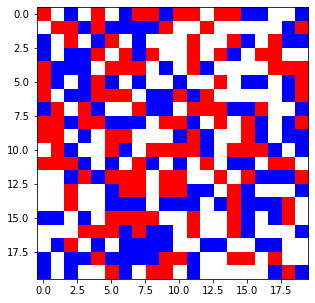

In [8]:
#print initial state
model = generate_model(lx,ly,fa,fb)
plt.figure(figsize=(7,5))
plt.imshow(model, cmap=cm.bwr, vmin = -1, vmax = 1)
path = 'init_16_1.05.png'
plt.savefig(path, dpi = 150)
#blue is shown as type A and red is shown as type B
plt.show()


In [9]:
nA_list, nB_list, counter = iterate_fixation(r,lx,ly,model)

One-race state reached
vacant = 388
A = 12
B = 0
number of total iterations =151808



<Figure size 432x288 with 0 Axes>

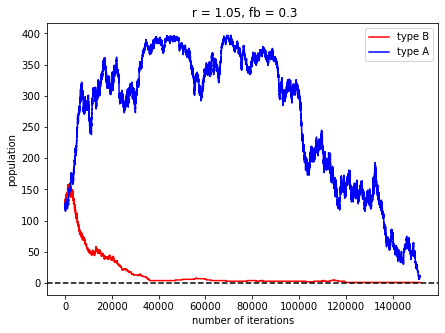

In [10]:
path = 'final_16_1.05.png'
plot_func(nA_list, nB_list, counter,r,fb, path)

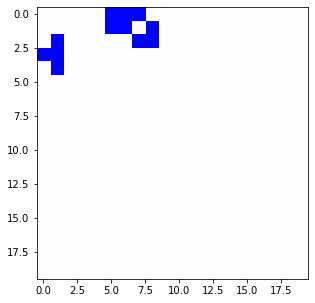

In [11]:
plt.figure(figsize=(7,5))
plt.imshow(model, cmap=cm.bwr, vmin = -1, vmax = 1)
path = 'final_image_16_1.05.png'
plt.savefig(path, dpi = 150)
#blue is shown as type A and red is shown as type B
plt.show()

# Initial condition: Emergence of one individual of type A

In [128]:
#Dimension of lattice
lx = 20
ly = 20

#fraction of different variants and of unoccupied spots
fb = 0.5

#relative fitness of varaint A
r = 1.05

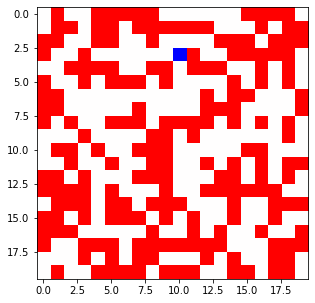

In [129]:
#print initial state
model_oneofA = generate_model_oneofA(lx,ly,fb)
plt.figure(figsize=(7,5))
plt.imshow(model_oneofA, cmap=cm.bwr, vmin = -1, vmax = 1)
path = 'init_15_1.05.png'
plt.savefig(path, dpi = 150)
#blue is shown as type A and red is shown as type B
#plt.savefig("One_of_variant_A/r_5_fb_0.5/initial_004.pdf",dpi = 150)
plt.show()

In [130]:
nA_list, nB_list, counter = iterate_fixation(r,lx,ly,model_oneofA)

One-race state reached
vacant = 388
A = 0
B = 12
number of total iterations =102532



<Figure size 432x288 with 0 Axes>

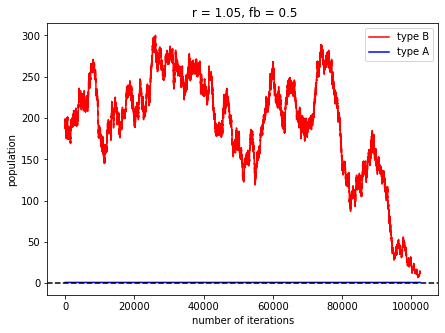

In [131]:
path = 'final_15_1.05.png'
plot_func(nA_list, nB_list, counter,r,fb, path)

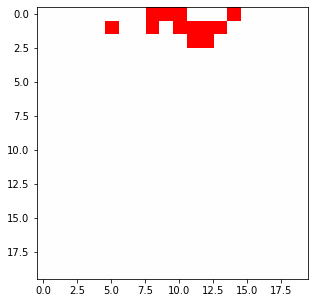

In [132]:
plt.figure(figsize=(7,5))
plt.imshow(model_oneofA, cmap=cm.bwr, vmin = -1, vmax = 1)
path = 'final_image_15_1.05.png'
plt.savefig(path, dpi = 150)
#blue is shown as type A and red is shown as type B
plt.show()

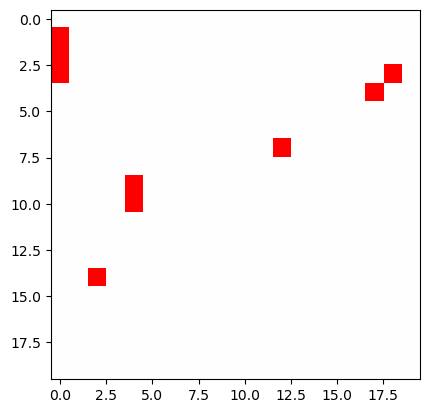

In [165]:
plt.imshow(model_oneofA, cmap=cm.bwr, vmin = -1, vmax = 1)
#blue is shown as type A and red is shown as type B
#plt.savefig("One_of_variant_A/r_5_fb_0.5/final_004.pdf",dpi = 150)
plt.show()